In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import models
from torchvision.transforms.functional import InterpolationMode

import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import random
import os
from torch.utils.data import Subset
import matplotlib.pyplot as plt

In [ ]:
# Change this to your own dataset path
train_img_dir = "ferplus/FER2013Plus/Images/FER2013Train"
val_img_dir   = "ferplus/FER2013Plus/Images/FER2013Valid"
train_lbl_csv = "ferplus/FER2013Plus/Labels/FER2013Train/label.csv"
val_lbl_csv   = "ferplus/FER2013Plus/Labels/FER2013Valid/label.csv"

class FERPlusSoftDataset(Dataset):
    def __init__(self, images_dir, label_csv_path, transform=None, confidence_threshold=0.4):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))

        df = pd.read_csv(label_csv_path, header=None)
        self.labels = df.iloc[:, 2:10].values.astype(np.float32)


        # Normalize votes to sum to 1 (turn votes into probability distribution)
        self.labels = self.labels / np.clip(self.labels.sum(axis=1, keepdims=True), 1e-6, None)

        # Filter samples based on vote confidence
        confident_indices = []
        for idx, label in enumerate(self.labels):
            if label.max() >= confidence_threshold:
                confident_indices.append(idx)

        self.image_files = [self.image_files[idx] for idx in confident_indices]
        self.labels = self.labels[confident_indices]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)

        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)

        label_soft = torch.tensor(self.labels[idx], dtype=torch.float32)

        return img, label_soft

class SoftLabelLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        log_preds = F.log_softmax(logits, dim=1)
        loss = F.kl_div(log_preds, targets, reduction='batchmean')
        return loss

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device):
    model.eval(); correct = total = 0
    for x, y_soft in loader:
        x = x.to(device)
        y_true = y_soft.argmax(dim=1).to(device)
        pred = model(x).argmax(1)
        correct += (pred == y_true).sum().item(); total += y_true.size(0)
    return correct / total

epochs      = 50
batch_size  = 256
lr          = 3e-4
random_seed = 42
use_gpu_id  = 0

torch.manual_seed(random_seed); np.random.seed(random_seed); random.seed(random_seed)
device = torch.device(f"cuda:{use_gpu_id}" if (torch.cuda.is_available() and use_gpu_id >= 0) else "cpu")
print("Using", device)

train_tfm = T.Compose([
    T.Grayscale(1),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=5),
    T.RandomRotation(10, interpolation=InterpolationMode.BILINEAR),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ColorJitter(0.1, 0.1),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])
val_tfm = T.Compose([
    T.Grayscale(1),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

train_ds = FERPlusSoftDataset(train_img_dir, train_lbl_csv, transform=train_tfm)
val_ds   = FERPlusSoftDataset(val_img_dir, val_lbl_csv, transform=val_tfm)

subset_percent = 1.0 
if subset_percent < 1.0:
    subset_size = int(len(train_ds) * subset_percent)
    indices = np.random.choice(len(train_ds), subset_size, replace=False)
    train_ds = Subset(train_ds, indices)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

n_classes = 8

model_name = "resnet50"

if model_name.startswith("resnet"):
    model = getattr(models, model_name)(weights="DEFAULT")
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 8)  # Force output to 8
else:
    model = models.efficientnet_b2(weights="DEFAULT")
    model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 8)  # Force output to 8


model.to(device)

criterion = SoftLabelLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))
scaler    = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

train_losses = []
val_accuracies = []

best = 0.0
for epoch in range(1, epochs + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

    running_loss = 0.0
    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        running_loss += loss.item() * x.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss_epoch = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)

    acc = evaluate(model, val_loader, device)
    val_accuracies.append(acc)

    print(f"Val acc: {acc:.4f}")
    if acc > best:
        best = acc
        torch.save(model.state_dict(), "best.pth")
        print("→ saved best.pth")

print(f"Training complete. Best validation accuracy = {best:.4f}")

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Progress")
plt.show()


Using cuda:0


Epoch 1/50: 100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.5538]


Val acc: 0.7530
→ saved best.pth


Epoch 2/50: 100%|██████████| 108/108 [00:33<00:00,  3.23it/s, loss=0.4446]


Val acc: 0.7994
→ saved best.pth


Epoch 3/50: 100%|██████████| 108/108 [00:33<00:00,  3.23it/s, loss=0.3547]


Val acc: 0.8037
→ saved best.pth


Epoch 4/50: 100%|██████████| 108/108 [00:33<00:00,  3.22it/s, loss=0.3183]


Val acc: 0.8181
→ saved best.pth


Epoch 5/50: 100%|██████████| 108/108 [00:33<00:00,  3.22it/s, loss=0.2880]


Val acc: 0.8295
→ saved best.pth


Epoch 6/50: 100%|██████████| 108/108 [00:33<00:00,  3.22it/s, loss=0.2852]


Val acc: 0.8381
→ saved best.pth


Epoch 7/50: 100%|██████████| 108/108 [00:33<00:00,  3.22it/s, loss=0.2847]


Val acc: 0.8350


Epoch 8/50: 100%|██████████| 108/108 [00:33<00:00,  3.21it/s, loss=0.2525]


Val acc: 0.8458
→ saved best.pth


Epoch 9/50: 100%|██████████| 108/108 [00:33<00:00,  3.21it/s, loss=0.2587]


Val acc: 0.8510
→ saved best.pth


Epoch 10/50: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s, loss=0.2247]


Val acc: 0.8484


Epoch 11/50: 100%|██████████| 108/108 [00:33<00:00,  3.20it/s, loss=0.2349]


Val acc: 0.8510


Epoch 12/50: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s, loss=0.2558]


Val acc: 0.8301


Epoch 13/50: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s, loss=0.2295]


Val acc: 0.8585
→ saved best.pth


Epoch 14/50: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s, loss=0.2225]


Val acc: 0.8519


Epoch 15/50: 100%|██████████| 108/108 [00:33<00:00,  3.20it/s, loss=0.2147]


Val acc: 0.8553


Epoch 16/50: 100%|██████████| 108/108 [00:34<00:00,  3.16it/s, loss=0.2034]


Val acc: 0.8579


Epoch 17/50: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s, loss=0.1982]


Val acc: 0.8424


Epoch 18/50: 100%|██████████| 108/108 [00:34<00:00,  3.17it/s, loss=0.1914]


Val acc: 0.8567


Epoch 19/50: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s, loss=0.1863]


Val acc: 0.8484


Epoch 20/50:  34%|███▍      | 37/108 [00:12<00:24,  2.94it/s, loss=0.1585]


KeyboardInterrupt: 

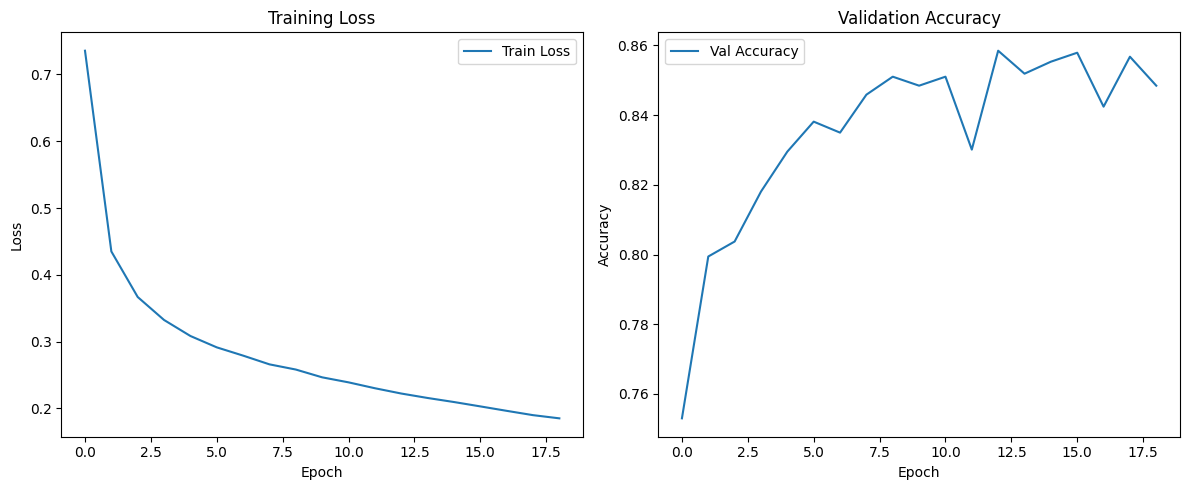

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()